In [1]:
# Standard Library
import datetime
import os
import re
from pathlib import Path

# Third Party Library
import joblib
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from omegaconf import DictConfig, OmegaConf
from scipy.stats import rankdata
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# First Party Library
import src.configs.visualization_configs as vcfg
# from src.utilities import find_project_root
from src.visualization import plot

In [2]:
plot.set_mpl_styles(fontsize=10)

In [3]:
colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]
markers = ["s", "D", "o", "p", "*", "h", "D", "8", "v", "x"]

model_name = "SimpleCAE16"
# trained_datetime = "2023-07-21/20-18-22"
extracted_datetime = datetime.datetime(2025, 2, 4, 8, 12 ,21)
# image_size = 64
# extracted_datetime = datetime.datetime(2024, 12, 20, 11, 18, 00)
image_size = 16


# project_dir = find_project_root()
project_dir = Path("/home/shinsei/MyResearches/feat_extrc")

model_save_pardir = project_dir / "models" / "VBGMM"
feature_pardir = (
    project_dir
    / "reports"
    / "features"
    / model_name
    / extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)
feature_figure_pardir = (
    project_dir
    / "reports"
    / "figures"
    / model_name
    / extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)
vbgmm_figure_pardir = (
    project_dir
    / "reports"
    / "figures"
    / "VBGMM"
    / extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)
image_pardir = (
    project_dir
    / f"data/processed/CNTForest/cnt_sem_{image_size}x{image_size}/10k/"
)

feature_train_csv_path = feature_pardir / "features_train_data.csv"
feature_check_csv_path = feature_pardir / "features_check_data.csv"

extraction_cfg = vcfg.ExtractionModelConfig(
    model_name, image_size, extracted_datetime.strftime("%Y-%m-%d/%H-%M-%S")
)

In [4]:
df_train = pl.read_csv(feature_train_csv_path)
X_train = df_train.select(
    pl.exclude(["target", "prediction", "filename", "dirname"])
).to_numpy()
metadata_train = df_train.select(pl.exclude(r"^column_\d+$")).with_row_count("id")
metadata_train.head()

id,dirname,filename
u32,i64,str
0,0,"""10k_0_h000_w00…"
1,0,"""10k_0_h000_w00…"
2,0,"""10k_0_h000_w00…"
3,0,"""10k_0_h000_w00…"
4,0,"""10k_0_h000_w00…"


In [5]:
df_check = pl.read_csv(feature_check_csv_path)
X_check = df_check.select(
    [pl.exclude(["target", "prediction", "filename", "dirname"])]
).to_numpy()
metadata_check = df_check.select(pl.exclude(r"^column_\d+$")).with_row_count("id")
metadata_check.head()

id,dirname,filename
u32,i64,str
0,0,"""10k_0_h000_w00…"
1,0,"""10k_0_h000_w00…"
2,0,"""10k_0_h000_w00…"
3,0,"""10k_0_h000_w00…"
4,0,"""10k_0_h000_w00…"


In [8]:
sc = StandardScaler()
minmax = MinMaxScaler((-1, 1))
pca = PCA(random_state=42)

X_train_std = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_std)
X_train_pca_minmax = minmax.fit_transform(X_train_pca)

X_check_std = sc.transform(X_check)
X_check_pca = pca.transform(X_check_std)
X_check_pca_minmax = minmax.transform(X_check_pca)

threshold = 0.5
cumsum_contrb_rate = pca.explained_variance_ratio_.cumsum()
max_index_thresh = np.where(cumsum_contrb_rate - threshold > 0, 1, 0).argmax()
num_use_features = max_index_thresh + 1
print(num_use_features)

26


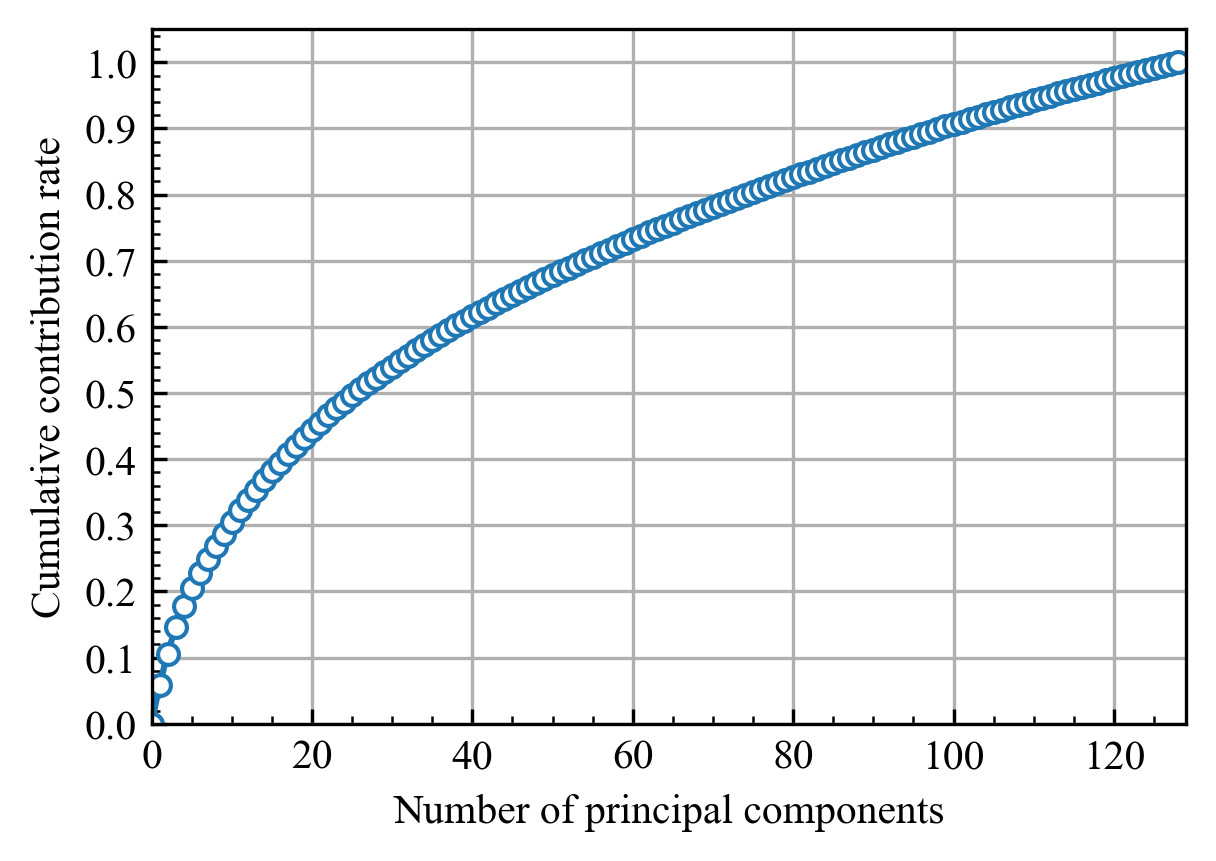

In [9]:
num_all_components = X_train.shape[1]
figsize_cm = [10, 7]
figsize=plot.cvt_unit(figsize_cm)

fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax = fig.add_subplot(1, 1, 1)

*_, lines, _ = plot.plot_cumulative_contribution_rate(
    cumsum_contrb_rate,
    ax,
    cumulated=True,
    threshold=threshold,
    # show_threshold=True,
)
lines[0].set_markerfacecolor("white")
lines[0].set_markersize(5)
if not feature_figure_pardir.exists():
    feature_figure_pardir.mkdir(parents=True)

# fig.savefig(feature_figure_pardir / "contribution_rate.svg", bbox_inches="tight")

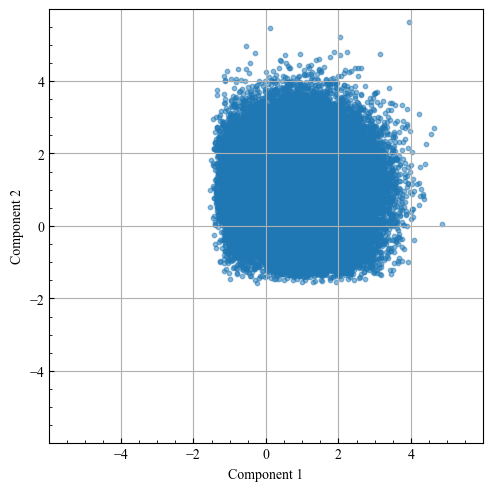

In [10]:
component_01 = df_train.select(
    [pl.col("column_0"), pl.col("column_1")]
).to_numpy()

# fig = plt.figure(layout="constrained")
# ax = fig.add_subplot(1,1,1)
# plot_scatter(ax, component_01.T)
# ax.set_xlabel("Component 1")
# ax.set_ylabel("Component 2")
fig, ax, _ = plot.plot_scatter(
    component_01.T,
    size=10,
    axis_labels=("Component 1", "Component 2"),
    color="tab:blue",
)

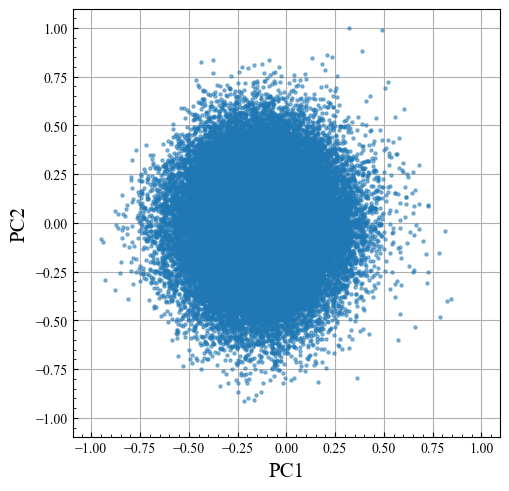

In [13]:
label_names = ("PC1", "PC2")
fig, ax, _ = plot.plot_scatter(
    X_check_pca_minmax.T,
    size=5,
)
ax.set_xlabel(label_names[0], fontsize=15)
ax.set_ylabel(label_names[1], fontsize=15)
ax.set_axisbelow(True)

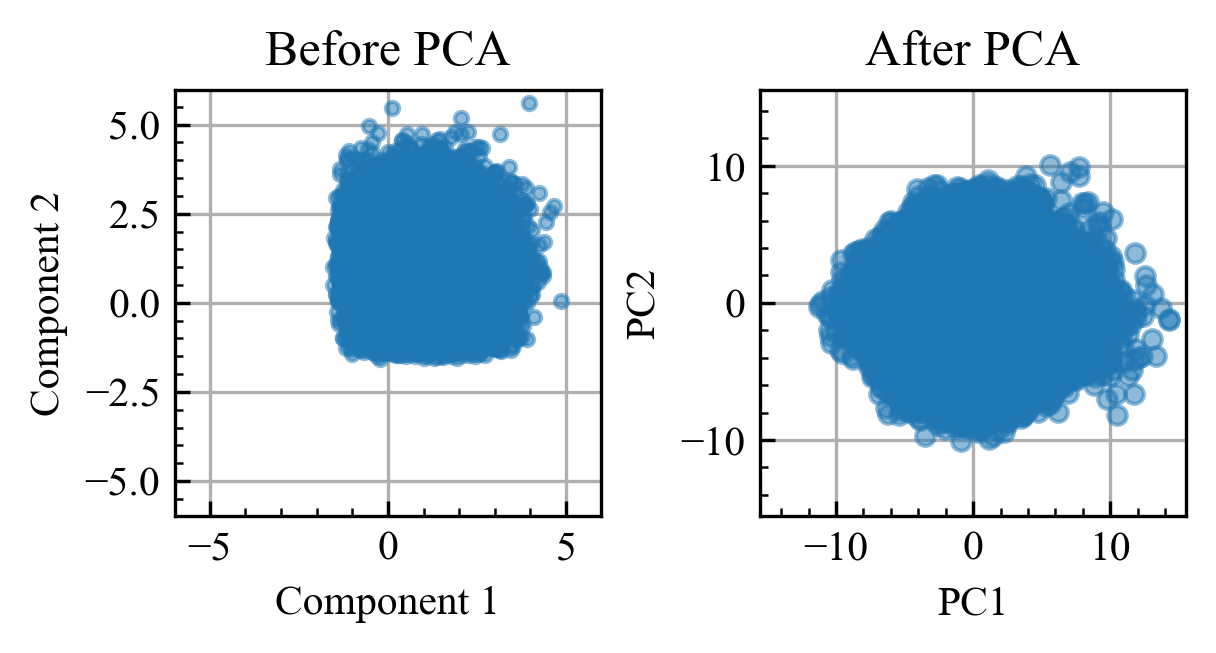

In [15]:
figsize_cm = [10, 7]
figsize=plot.cvt_unit(figsize_cm)
fig = plt.figure(figsize=figsize, layout="constrained", dpi=300)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_title("Before PCA")
ax2.set_title("After PCA")
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

plot.plot_scatter(
    X_train.T, axis_labels=("Component 1", "Component 2"), ax=ax1, size=10,
)
plot.plot_scatter(X_train_pca.T, axis_labels=("PC1", "PC2"), ax=ax2)


if not feature_figure_pardir.exists():
    feature_figure_pardir.mkdir(parents=True)
# fig.savefig(
#     feature_figure_pardir / "distribution_before-after_PCA.png",
#     dpi=300,
#     bbox_inches="tight",
# )

In [17]:
clusterized_datetime = datetime.datetime.now()
nc = 10
max_iter = 1000

clustering_type = f"vbgmm_pca_{num_use_features}_{nc}clusters"
print(clustering_type)

vbgmm_train_pca = BayesianGaussianMixture(
    n_components=nc,
    max_iter=max_iter,
    n_init=10,
    init_params="k-means++",
    verbose=1,
    verbose_interval=50,
    random_state=42,
)
y_train_pca = vbgmm_train_pca.fit_predict(X_train_pca[:, :num_use_features])

vbgmm_pca_26_10clusters
Initialization 0
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
  Iteration 300
  Iteration 350
  Iteration 400
  Iteration 450
  Iteration 500
  Iteration 550
  Iteration 600
  Iteration 650
  Iteration 700
  Iteration 750
  Iteration 800
  Iteration 850
  Iteration 900
  Iteration 950
  Iteration 1000
Initialization did not converge.
Initialization 1
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
  Iteration 300
Initialization converged.
Initialization 2
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
  Iteration 300
  Iteration 350
  Iteration 400
  Iteration 450
  Iteration 500
  Iteration 550
  Iteration 600
  Iteration 650
  Iteration 700
  Iteration 750
  Iteration 800
  Iteration 850
  Iteration 900
  Iteration 950
  Iteration 1000
Initialization did not converge.
Initialization 3
  Iteration 50
  Iteration 100
  Iteration 150
  Iteration 200
  Iteration 250
  

/home/shinsei/MyResearches/feat_extrc/.venv/lib/python3.10/site-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [18]:
rank_of_cluster_train_pca = (
    rankdata(
        np.histogram(y_train_pca, bins=nc, range=(0, nc))[0], method="ordinal"
    )
    - 1
)
y_train_pca_sorted_cluster = rank_of_cluster_train_pca[y_train_pca]

In [19]:
rank_of_cluster_train_pca

array([3, 8, 5, 9, 7, 4, 6, 1, 2, 0])

In [20]:
# clusterized_datetime = datetime.datetime.now()
clustering_cfg = vcfg.ClusteringModelConfig(
    clustering_type,
    max_iter,
    int(num_use_features),
    nc,
    clusterized_datetime.strftime("%Y-%m-%d/%H-%M-%S"),
)

clstdt_str = clusterized_datetime.strftime("%Y-%m-%d/%H-%M-%S")
model_save_dir = model_save_pardir / clstdt_str

if not model_save_dir.exists():
    os.makedirs(model_save_dir)
joblib.dump(
    vbgmm_train_pca, model_save_dir / f"{clustering_type}_iter{max_iter}.pkl"
)

oconf: DictConfig = OmegaConf.structured(
    vcfg.VisConfigs(extraction_cfg, clustering_cfg)
)
with open(model_save_dir / "config.yaml", "w") as f:
    f.writelines(OmegaConf.to_yaml(oconf))

Text(0, 0.5, 'weight of each component')

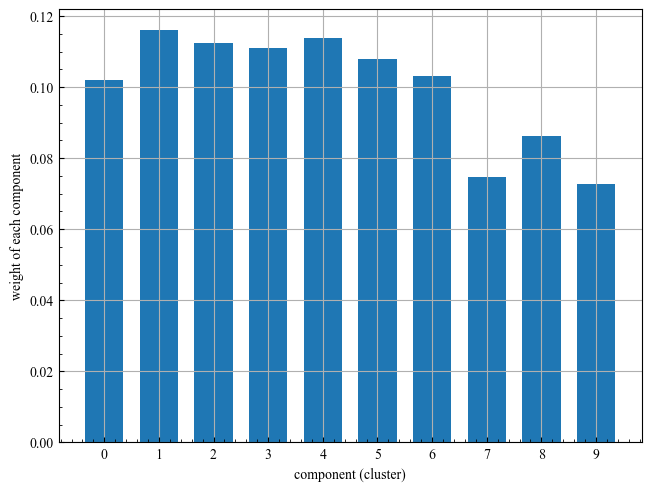

In [21]:
clusters = tuple(range(nc))
fig = plt.figure(layout="constrained")
ax = fig.add_subplot(1, 1, 1)
ax.bar(clusters, vbgmm_train_pca.weights_, width=0.7, tick_label=clusters)
ax.set_xlabel("component (cluster)")
ax.set_ylabel("weight of each component")

TypeError: plot_bar() got an unexpected keyword argument 'label_names'

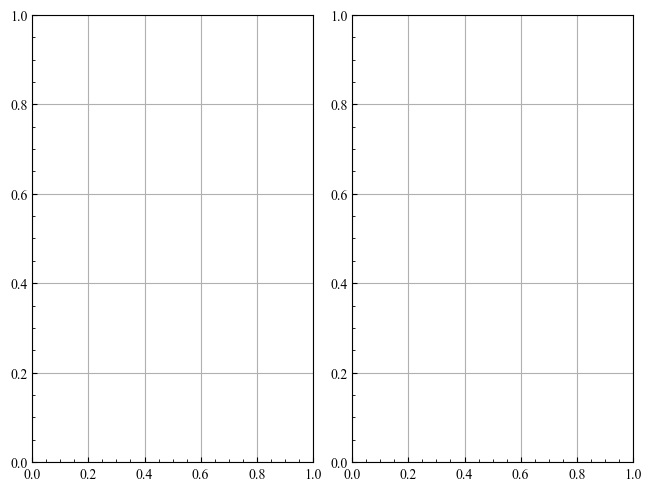

In [22]:
y_check_pca = vbgmm_train_pca.predict(X_check_pca[:, :num_use_features])
y_check_pca_sorted_cluster = rank_of_cluster_train_pca[y_check_pca]

fig = plt.figure(layout="constrained")
axr = fig.add_subplot(1, 2, 1)
axl = fig.add_subplot(1, 2, 2)
plot.plot_bar(
    y_train_pca,
    ax=axr,
    label_names=("Cluster number", "Count of cluster"),
    num_bins=nc,
)
plot.plot_bar(
    y_check_pca,
    ax=axl,
    label_names=("Cluster number", "Count of cluster"),
    num_bins=nc,
)

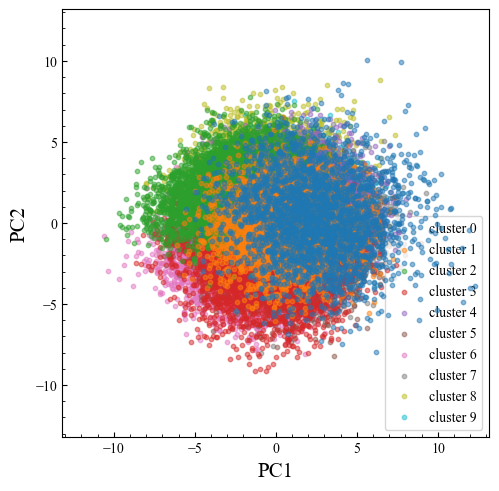

In [23]:
fig = plt.figure(layout="constrained")
ax = fig.add_subplot()
cmap = plt.get_cmap("tab10")
for c in np.unique(y_check_pca_sorted_cluster):
    mask = y_check_pca_sorted_cluster == c
    X_masked = X_check_pca[mask, :2].T
    _, pc = plot.plot_scatter(
        X_masked,
        ax,
        size=10,
        color=cmap(c),
    )
    pc.set_label(f"cluster {c}")
    pc.set_zorder(nc - c)
ax.set_xlabel(label_names[0], fontsize=15)
ax.set_ylabel(label_names[1], fontsize=15)

ax.legend()
ax.grid()
ax.set_axisbelow(True)

In [26]:
make_file_path_col = pl.concat_str(
    [pl.col("dirname"), pl.col("filename")], separator="/"
).alias("filepath")
train_features_pca = pl.concat(
    (
        pl.from_numpy(X_train_pca),
        df_train.select(make_file_path_col),
        pl.DataFrame({"cluster": y_train_pca_sorted_cluster}),
    ),
    how="horizontal",
)
clstdt_str = clusterized_datetime.strftime("%Y-%m-%d-%H-%M-%S")
train_features_pca.write_csv(
    feature_pardir / f"features_train_data_pca_with_clusters_{clstdt_str}.csv",
)

In [27]:
make_file_path_col = pl.concat_str(
    [pl.col("dirname"), pl.col("filename")], separator="/"
).alias("filepath")
check_features_pca = pl.concat(
    (
        pl.from_numpy(X_check_pca),
        df_check.select(make_file_path_col),
        pl.DataFrame({"cluster": y_check_pca_sorted_cluster}),
    ),
    how="horizontal",
)
clstdt_str = clusterized_datetime.strftime("%Y-%m-%d-%H-%M-%S")
check_features_pca.write_csv(
    feature_pardir / f"features_check_data_pca_with_clusters_{clstdt_str}.csv",
)

max_abs_range=32.00419246805015


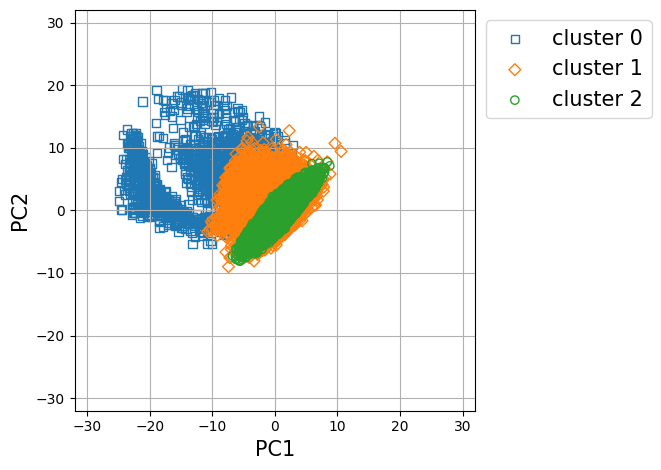

In [ ]:
plot.scatter_each_classes(
    X_train_pca,
    # cluster_labels,
    class_labels=y_train_pca_sorted_cluster - 1,
    rank=np.arange(0, 10),
    # y_train_pca,
    markers=markers,
    colors=colors,
    xylabel=("PC1", "PC2"),
    face_color="None",
    fontsize=15,
    # path=scatter_save_path,
    # path="../reports/figures/VBGMM/2023-07-14/cluster_images/scatter.png"
    # path = figure_pardir / f"cluster_images_iter{max_iter}" / f"scatter_iter{max_iter}.png"
)

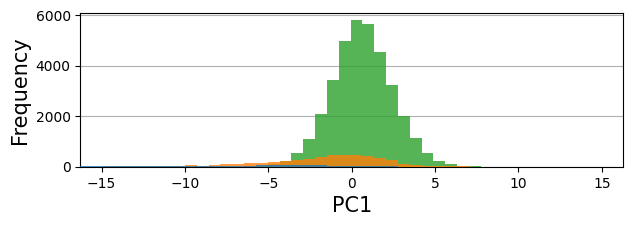

In [42]:
x_min = -16.268626574593476
x_max = 16.268626574593476
fontsize = 15

df_pc1 = pl.DataFrame(X_train_pca[:, 0]).with_columns(
    train_features_pca.select([pl.col("cluster")])
)

min_max = (
    df_pc1.select(pl.col("column_0"))
    .describe()
    .filter((pl.col("describe") == "max") | (pl.col("describe") == "min"))
    .select(pl.col("column_0"))
    .to_numpy()
    .flatten()
)

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 1, 1)

for i in range(10):
    pc1 = (
        df_pc1.filter(pl.col("cluster") == i)
        .select("column_0")
        .to_numpy()
        .flatten()
    )

    ax.hist(
        pc1,
        bins=50,
        range=min_max,
        alpha=0.8,
        label=f"cluster_{i}",
        zorder=10 - i,
    )
ax.set_xlim(x_min, x_max)
ax.set_ylim(
    0,
)

ax.set_xlabel("PC1", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)
ax.grid(axis="y")

# fig.savefig(
#     fname=figure_pardir / f"cluster_images_iter{max_iter}" / "frequency_pc1.png",
#     dpi=fig.get_dpi(),
#     bbox_inches="tight"
# )

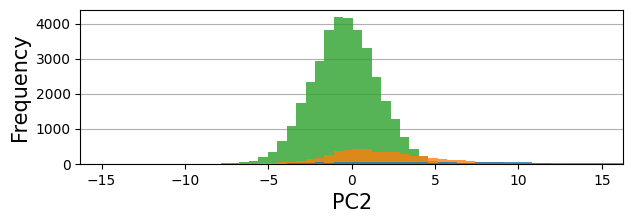

In [46]:
df_pc2 = pl.DataFrame(X_train_pca[:, 1]).with_columns(
    train_features_pca.select([pl.col("cluster")])
)

min_max = (
    df_pc2.select(pl.col("column_0"))
    .describe()
    .filter((pl.col("describe") == "max") | (pl.col("describe") == "min"))
    .select(pl.col("column_0"))
    .to_numpy()
    .flatten()
)

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 1, 1)

for i in range(10):
    pc1 = (
        df_pc2.filter(pl.col("cluster") == i)
        .select("column_0")
        .to_numpy()
        .flatten()
    )

    ax.hist(
        pc1,
        bins=50,
        range=min_max,
        alpha=0.8,
        label=f"cluster_{i}",
        zorder=10 - i,
    )
ax.set_xlim(x_min, x_max)
ax.set_ylim(
    0,
)

ax.set_xlabel("PC2", fontsize=fontsize)
ax.set_ylabel("Frequency", fontsize=fontsize)
ax.grid(axis="y")
# fig.savefig(
#     fname=figure_pardir / f"cluster_images_iter{max_iter}" / "frequency_pc2.png",
#     dpi=fig.get_dpi(),
#     bbox_inches="tight"
# )

In [18]:
model_save_dir

PosixPath('/home/shinsei/MyResearchs/feat_extrc/models/VBGMM/2023-07-10/13-09-32')